In [34]:
import jax.numpy as jnp
import jax
from jax import vmap, jit, jacfwd
import optax
from functools import partial
import numpy as np
from tqdm import trange
from jax import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import sys
sys.path.insert(0, '../')

from KAN import KAN


def create_interior_points(L_range, H_range, T_range, nx, ny, nt):
    """Create interior points following the original structure"""
    x = np.linspace(L_range[0], L_range[1], nx)
    y = np.linspace(H_range[0], H_range[1], ny)
    t = np.linspace(T_range[0], T_range[1], nt)
    return x, y, t

def create_boundary_points(L_range, H_range, nx, ny):
    """Create boundary points following the original structure"""
    x = np.linspace(L_range[0], L_range[1], nx)
    y = np.linspace(H_range[0], H_range[1], ny)

    x_left = jnp.array([L_range[0]])
    y_left = y

    x_top = x
    y_top = jnp.array([H_range[1]])

    x_right = jnp.array([L_range[1]])
    y_right = y

    x_bottom = x
    y_bottom = jnp.array([H_range[0]])

    return (x_left, y_left), (x_top, y_top), (x_right, y_right), (x_bottom, y_bottom)

# Define the domain
L_range = (0., 1.0)
H_range = (0., 1.0)
T_range = (0.0, 10.0)

# Grid resolution
nx, ny, nt = 200, 200, 200

# Create interior points
x_interior, y_interior, t_interior = create_interior_points(L_range, H_range, T_range, nx, ny, nt)

# Initial condition points are the same as interior x, y points
x_ic = x_interior
y_ic = y_interior
t_ic = jnp.array([0.])

# Create boundary points
(x_left, y_left), (x_top, y_top), (x_right, y_right), (x_bottom, y_bottom) = create_boundary_points(L_range, H_range, nx, ny)

# For boundary conditions, use the interior time points
t_bc = t_interior

X, Y, T = np.meshgrid(x_interior, y_interior, t_interior, indexing='ij')

In [35]:
class SF_KAN_Separable:
    def __init__(self, layer_dims, init_lr, k=3, r=10):
        self.input_size = layer_dims[0]
        self.out_size = layer_dims[-1]
        self.r = r
        self.layer_dims = [self.input_size] + layer_dims[1:-1] + [self.r * self.out_size]
        
        self.model_x = KAN(layer_dims=self.layer_dims, k=k, const_spl=False, const_res=False, add_bias=True, grid_e=0.02, j='0')
        self.model_y = KAN(layer_dims=self.layer_dims, k=k, const_spl=False, const_res=False, add_bias=True, grid_e=0.02, j='0')
        self.model_t = KAN(layer_dims=self.layer_dims, k=k, const_spl=False, const_res=False, add_bias=True, grid_e=0.02, j='0')
        
        key1, key2, key3 = jax.random.split(jax.random.PRNGKey(10), 3)
        self.variables_x = self.model_x.init(key1, jnp.ones([1, 1]))
        self.variables_y = self.model_y.init(key2, jnp.ones([1, 1]))
        self.variables_t = self.model_t.init(key3, jnp.ones([1, 1]))
        
        self.optimizer = optax.adam(learning_rate=init_lr, nesterov=True)
        self.opt_state_x = self.optimizer.init(self.variables_x['params'])
        self.opt_state_y = self.optimizer.init(self.variables_y['params'])
        self.opt_state_t = self.optimizer.init(self.variables_t['params'])

    def predict(self, x, y, t):
        variables_x, variables_y, variables_t = self.variables_x, self.variables_y, self.variables_t
        preds, _ = self.forward_pass(variables_x, variables_y, variables_t, x, y, t)
        return preds

    @partial(jit, static_argnums=(0,))
    def forward_pass(self, variables_x, variables_y, variables_t, x, y, t):
        preds_x, spl_regs_x = self.model_x.apply(variables_x, x[:, None])
        preds_y, spl_regs_y = self.model_y.apply(variables_y, y[:, None])
        preds_t, spl_regs_t = self.model_t.apply(variables_t, t[:, None])
        
        preds_x = preds_x.reshape(-1, self.out_size, self.r)
        preds_y = preds_y.reshape(-1, self.out_size, self.r)
        preds_t = preds_t.reshape(-1, self.out_size, self.r)
        
        preds = jnp.einsum('ijk,ljk,mjk->ilm', preds_x, preds_y, preds_t)
        spl_regs = spl_regs_x + spl_regs_y + spl_regs_t
        
        return preds, spl_regs

    @partial(jit, static_argnums=(0,))
    def loss(self, params_x, params_y, params_t, state_x, state_y, state_t, *args):
        variables_x = {'params': params_x, 'state': state_x}
        variables_y = {'params': params_y, 'state': state_y}
        variables_t = {'params': params_t, 'state': state_t}
        return self.loss_fn(variables_x, variables_y, variables_t, *args)

    @partial(jit, static_argnums=(0,))
    def train_step(self, params_x, params_y, params_t, state_x, state_y, state_t, 
                  opt_state_x, opt_state_y, opt_state_t, *args):
        (loss_value, (physics_loss, boundary_loss)), grads = jax.value_and_grad(self.loss, has_aux=True, argnums=(0,1,2))(
            params_x, params_y, params_t, state_x, state_y, state_t, *args
        )
        grads_x, grads_y, grads_t = grads

        updates_x, opt_state_x = self.optimizer.update(grads_x, opt_state_x)
        updates_y, opt_state_y = self.optimizer.update(grads_y, opt_state_y)
        updates_t, opt_state_t = self.optimizer.update(grads_t, opt_state_t)

        params_x = optax.apply_updates(params_x, updates_x)
        params_y = optax.apply_updates(params_y, updates_y)
        params_t = optax.apply_updates(params_t, updates_t)

        return params_x, params_y, params_t, opt_state_x, opt_state_y, opt_state_t, loss_value, physics_loss, boundary_loss

    def train(self, num_epochs, *args):
        params_x, state_x = self.variables_x['params'], self.variables_x['state']
        params_y, state_y = self.variables_y['params'], self.variables_y['state']
        params_t, state_t = self.variables_t['params'], self.variables_t['state']
        opt_state_x, opt_state_y, opt_state_t = self.opt_state_x, self.opt_state_y, self.opt_state_t
        loss_history = []

        pbar = trange(num_epochs, smoothing=0.)
        for epoch in pbar:            
            (params_x, params_y, params_t, opt_state_x, opt_state_y, opt_state_t, 
             loss_value, physics_loss, boundary_loss) = self.train_step(
                params_x, params_y, params_t, state_x, state_y, state_t,
                opt_state_x, opt_state_y, opt_state_t, *args
            )
            
            loss_history.append(loss_value)

            if epoch % 10 == 0:
                pbar.set_postfix({
                    'Total Loss': f"{loss_value:.4e}",
                    'Physics Loss': f"{physics_loss:.4e}",
                    'Boundary Loss': f"{boundary_loss:.4e}"
                })
        
        self.variables_x = {'params': params_x, 'state': state_x}
        self.variables_y = {'params': params_y, 'state': state_y}
        self.variables_t = {'params': params_t, 'state': state_t}
        return loss_history

class KleinGordon_SF_KAN_Separable(SF_KAN_Separable):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def exact_solution(self, x, y, t):
        return (x + y) * jnp.cos(t) + x * y * jnp.sin(t)

    def forcing_term(self, x, y, t):
        u = self.exact_solution(x, y, t)
        return u**2 - u

    @partial(jit, static_argnums=(0,))
    def compute_residuals(self, variables_x, variables_y, variables_t, x_interior, y_interior, t_interior):
        def model_x_func(x):
            x_feat = self.model_x.apply(variables_x, x.reshape(-1, 1))[0]
            x_feat = x_feat.reshape(self.out_size, self.r)
            return x_feat

        def model_y_func(y):
            y_feat = self.model_y.apply(variables_y, y.reshape(-1, 1))[0]
            y_feat = y_feat.reshape(self.out_size, self.r)
            return y_feat

        def model_t_func(t):
            t_feat = self.model_t.apply(variables_t, t.reshape(-1, 1))[0]
            t_feat = t_feat.reshape(self.out_size, self.r)
            return t_feat

        x_feats = vmap(model_x_func)(x_interior)
        y_feats = vmap(model_y_func)(y_interior)
        t_feats = vmap(model_t_func)(t_interior)

        x_grads = vmap(jacfwd(model_x_func))(x_interior)
        y_grads = vmap(jacfwd(model_y_func))(y_interior)
        t_grads = vmap(jacfwd(model_t_func))(t_interior)

        x_hess = vmap(jacfwd(jacfwd(model_x_func)))(x_interior)
        y_hess = vmap(jacfwd(jacfwd(model_y_func)))(y_interior)
        t_hess = vmap(jacfwd(jacfwd(model_t_func)))(t_interior)

        # Get components
        u_x = x_feats[:, 0, :]
        u_y = y_feats[:, 0, :]
        u_t = t_feats[:, 0, :]

        du_dx = x_grads[:, 0, :]
        du_dy = y_grads[:, 0, :]
        du_dt = t_grads[:, 0, :]

        d2u_dx2 = x_hess[:, 0, :]
        d2u_dy2 = y_hess[:, 0, :]
        d2u_dt2 = t_hess[:, 0, :]

        # Combine using einsum
        u = jnp.einsum('ir,jr,kr->ijk', u_x, u_y, u_t)
        u_tt = jnp.einsum('ir,jr,kr->ijk', u_x, u_y, d2u_dt2)
        u_xx = jnp.einsum('ir,jr,kr->ijk', d2u_dx2, u_y, u_t)
        u_yy = jnp.einsum('ir,jr,kr->ijk', u_x, d2u_dy2, u_t)

        # Klein-Gordon equation residual
        f = self.forcing_term(x_interior[:, None, None], 
                            y_interior[None, :, None], 
                            t_interior[None, None, :])
        residual = u_tt - (u_xx + u_yy) + u**2 - f

        return residual

    @partial(jit, static_argnums=(0,))
    def loss_fn(self, variables_x, variables_y, variables_t, 
                x_interior, y_interior, t_interior,
                x_ic, y_ic, t_ic,
                x_left, y_left,
                x_top, y_top,
                x_right, y_right,
                x_bottom, y_bottom,
                t_bc):
        # Physics loss
        residuals = self.compute_residuals(variables_x, variables_y, variables_t, 
                                         x_interior, y_interior, t_interior)
        physics_loss = jnp.mean(jnp.square(residuals))
        
        # Initial condition loss (t=0)
        ic_pred = self.forward_pass(variables_x, variables_y, variables_t, 
                                  x_ic, y_ic, t_ic)[0]
        
        ic_exact = self.exact_solution(x_ic[:, None, None], 
                                     y_ic[None, :, None], 
                                     t_ic[None, None, :])
        ic_loss = jnp.mean(jnp.square(ic_pred - ic_exact))
        
        # Boundary losses
        bc_left = self.forward_pass(variables_x, variables_y, variables_t, 
                                  x_left, y_left, t_bc)[0]
        bc_left_exact = self.exact_solution(x_left[:, None, None], 
                                          y_left[None, :, None], 
                                          t_bc[None, None, :])

        bc_right = self.forward_pass(variables_x, variables_y, variables_t, 
                                   x_right, y_right, t_bc)[0]
        bc_right_exact = self.exact_solution(x_right[:, None, None], 
                                           y_right[None, :, None], 
                                           t_bc[None, None, :])

        bc_bottom = self.forward_pass(variables_x, variables_y, variables_t, 
                                    x_bottom, y_bottom, t_bc)[0]
        bc_bottom_exact = self.exact_solution(x_bottom[:, None, None], 
                                            y_bottom[None, :, None], 
                                            t_bc[None, None, :])
        
        bc_top = self.forward_pass(variables_x, variables_y, variables_t, 
                                 x_top, y_top, t_bc)[0]
        bc_top_exact = self.exact_solution(x_top[:, None, None], 
                                         y_top[None, :, None], 
                                         t_bc[None, None, :])

        # Combine boundary losses
        bc_loss = (jnp.mean(jnp.square(bc_left - bc_left_exact)) +
                  jnp.mean(jnp.square(bc_right - bc_right_exact)) +
                  jnp.mean(jnp.square(bc_bottom - bc_bottom_exact)) +
                  jnp.mean(jnp.square(bc_top - bc_top_exact)))

        # Total boundary loss
        boundary_loss = ic_loss + bc_loss
        
        return physics_loss + boundary_loss, (physics_loss, boundary_loss)

In [36]:
# Model parameters
layer_dims = [1, 5, 5, 1]  # Input dim is 1, output dim is 1
init_lr = 1e-3
r = 10 # SPIKAN latent dimension

# KAN parameters
k = 3 # spline order

# Initialize model
model = KleinGordon_SF_KAN_Separable(
    layer_dims=layer_dims,
    init_lr=init_lr,
    k=k,
    r=r
)

# Train the model
num_epochs = 50000
loss_history = model.train( 
    num_epochs,
    x_interior, y_interior, t_interior, # Interior points
    x_ic, y_ic, t_ic,                   # Initial condition
    x_left, y_left,                     # Left boundary
    x_top, y_top,                       # Top boundary
    x_right, y_right,                   # Right boundary
    x_bottom, y_bottom,                 # Bottom boundary
    t_bc                                # Time points for boundaries
)



100%|██████████| 50000/50000 [06:31<00:00, 127.80it/s, Total Loss=8.1732e-04, Physics Loss=6.6471e-04, Boundary Loss=1.5261e-04]


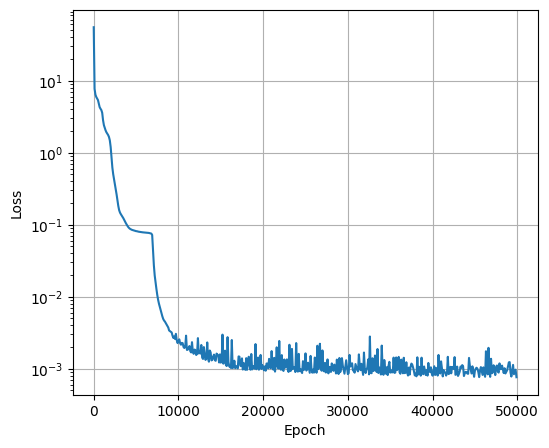

In [37]:
# Plot loss history
def plot_loss_history(loss_history):
    plt.figure(figsize=(6, 5))
    epochs = range(0, len(loss_history), 100)
    plt.plot(epochs, loss_history[::100])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for y-axis
    plt.grid(True)
    plt.show()

plot_loss_history(loss_history)


L2 error at t = 0.0: 1.483811e-03
L2 error at t = 1.836734693877551: 1.088443e-03
L2 error at t = 1.0: 1.816622e-03


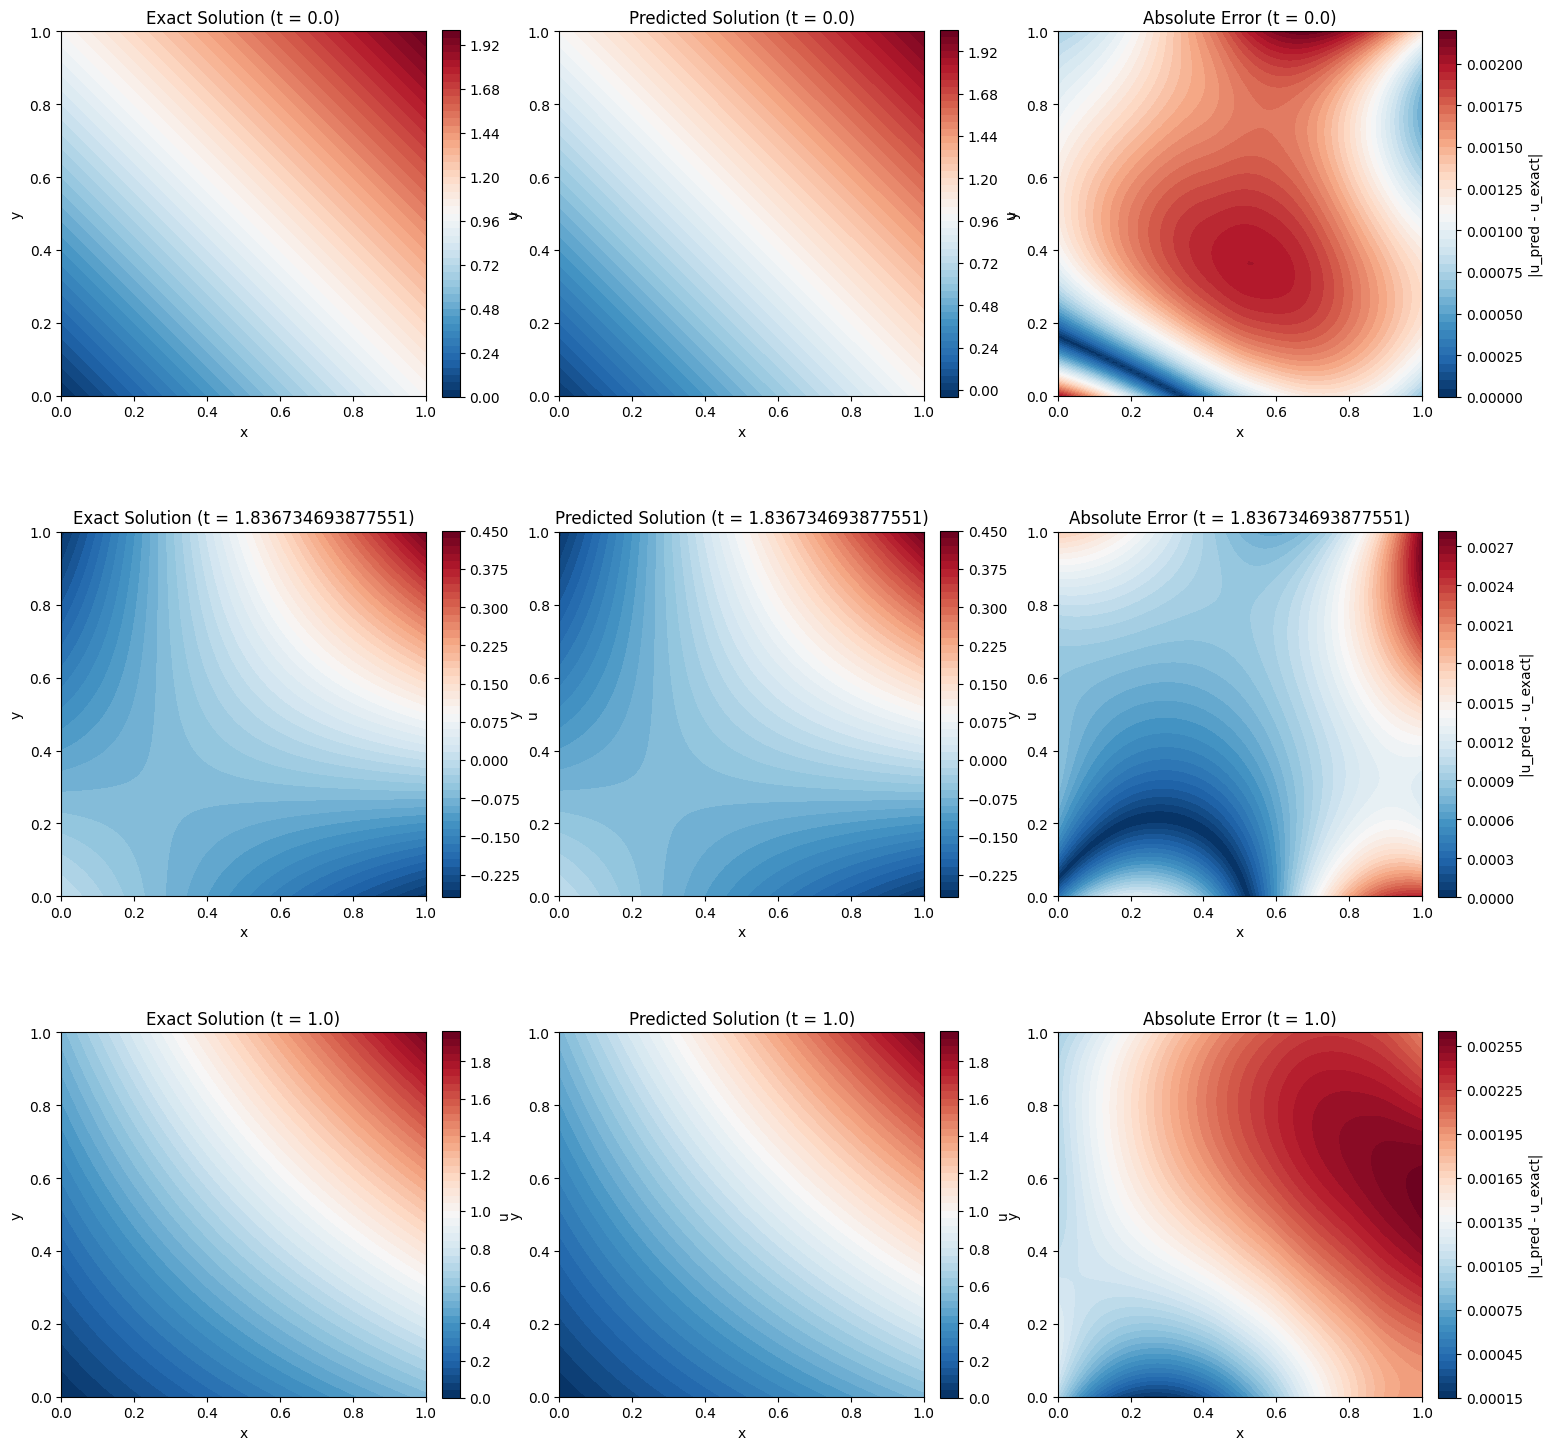

In [38]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize


def plot_klein_gordon_results(model, L_range, H_range, t_slices=[0., 0.5, 1.0]):
    """Plot exact solution, predicted solution, and errors at different time slices"""
    # Generate plotting grid
    nx_plot, ny_plot = 100, 100
    x_plot = jnp.linspace(L_range[0], L_range[1], nx_plot)
    y_plot = jnp.linspace(H_range[0], H_range[1], ny_plot)
    X_mesh, Y_mesh = jnp.meshgrid(x_plot, y_plot)
    
    # Number of time slices to plot
    n_times = len(t_slices)
    
    # Create figure
    fig = plt.figure(figsize=(18, 6*n_times))
    gs = gridspec.GridSpec(n_times, 3, width_ratios=[1, 1, 1], 
                          wspace=0.25, hspace=0.3)
    
    # Plot for each time slice
    for i, t in enumerate(t_slices):
        # Get predictions using 1D arrays
        pred = model.predict(x_plot, y_plot, jnp.array([t]))
        pred = pred.reshape(nx_plot, ny_plot)
        
        # Get exact solution on mesh
        exact = model.exact_solution(X_mesh, Y_mesh, t)
        
        # Compute error
        error = np.abs(pred - exact)
        
        # Compute L2 error for this time slice
        l2_error = np.sqrt(np.mean((pred - exact)**2))
        print(f"L2 error at t = {t}: {l2_error:.6e}")
        
        # Plot exact solution
        ax_exact = plt.subplot(gs[i, 0])
        im_exact = ax_exact.contourf(X_mesh, Y_mesh, exact, levels=50, cmap='RdBu_r')
        plt.colorbar(im_exact, ax=ax_exact, fraction=0.046, pad=0.04, label='u')
        ax_exact.set_title(f'Exact Solution (t = {t})')
        ax_exact.set_aspect('equal')
        ax_exact.set_xlabel('x')
        ax_exact.set_ylabel('y')
        
        # Plot predicted solution
        ax_pred = plt.subplot(gs[i, 1])
        im_pred = ax_pred.contourf(X_mesh, Y_mesh, pred, levels=50, cmap='RdBu_r')
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, label='u')
        ax_pred.set_title(f'Predicted Solution (t = {t})')
        ax_pred.set_aspect('equal')
        ax_pred.set_xlabel('x')
        ax_pred.set_ylabel('y')
        
        # Plot error
        ax_error = plt.subplot(gs[i, 2])
        im_error = ax_error.contourf(X_mesh, Y_mesh, error, levels=50, cmap='RdBu_r')
        plt.colorbar(im_error, ax=ax_error, fraction=0.046, pad=0.04, 
                    label='|u_pred - u_exact|')
        ax_error.set_title(f'Absolute Error (t = {t})')
        ax_error.set_aspect('equal')
        ax_error.set_xlabel('x')
        ax_error.set_ylabel('y')
    
    # plt.tight_layout()
    plt.show()

# After training, call the plotting function with the domain ranges
plot_klein_gordon_results(model, L_range, H_range, t_slices=[0., 5., 10.0])


In [29]:
def count_trainable_params(variables_x, variables_y):
    # Flatten the parameter trees
    flat_params_x, _ = jax.tree_util.tree_flatten(variables_x['params'])
    flat_params_y, _ = jax.tree_util.tree_flatten(variables_y['params'])
    
    # Sum the number of elements in each parameter array for both models
    total_params_x = sum(p.size for p in flat_params_x)
    total_params_y = sum(p.size for p in flat_params_y)
    
    # Total trainable parameters in the entire separable model
    total_params = total_params_x + total_params_y
    return total_params

# Assuming `variables_x` and `variables_y` have been initialized in your model
num_params = count_trainable_params(model.variables_x, model.variables_y)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 1320


In [30]:
# Get predictions
pred = model.predict(x_interior, y_interior, t_interior)

# Get exact solution
exact = model.exact_solution(x_interior[:, None], y_interior[:, None], t_interior[:, None])

In [31]:
# Predictions for plotting - use full grid
nx_plot, ny_plot, nt_plot = nx, ny, nt
x_plot = jnp.linspace(L_range[0], L_range[1], nx_plot)
y_plot = jnp.linspace(H_range[0], H_range[1], ny_plot)
t_plot = jnp.linspace(T_range[0], T_range[1], nt_plot)
X_mesh, Y_mesh = jnp.meshgrid(x_plot, y_plot)

# Make predictions for all time steps
u_pred = model.predict(x_plot, y_plot, t_plot)

# Get exact solutions for comparison
T_mesh, Y_mesh_t, X_mesh_t = jnp.meshgrid(t_plot, y_plot, x_plot, indexing='ij')
u_exact = model.exact_solution(X_mesh_t, Y_mesh_t, T_mesh)

# Compute absolute error
u_error = np.abs(u_pred - u_exact)

# Compute L2 error
l2_error = 100 * np.sqrt(np.mean((u_pred - u_exact)**2)) / np.sqrt(np.mean(u_exact**2))

output_data = {
    'mesh': {
        'nx': nx,
        'ny': ny,
        'nt': nt,
        'L_range': L_range,
        'H_range': H_range,
        'T_range': T_range
    },
    'field_variables': {
        'u_pred': u_pred,     # Shape: (nx, ny, nt)
        'u_exact': u_exact,   # Shape: (nx, ny, nt)
        'u_error': u_error    # Shape: (nx, ny, nt)
    },
    'training': {
        'loss_history': loss_history,
        'l2_error': l2_error
    }
}


# Save data
np.save(f'./data/2d_kg_spikan_nx{nx}_ny{ny}_nt{nt}_epochs{num_epochs}_k{k}_r{r}.npy', output_data)
